In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial.distance
import seaborn as sns
import sqlalchemy

from dtaidistance import clustering
from dtaidistance import dtw
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats

from database_credentials import get_database_url
from load_transform import load_transform_combine, pivot
from sampling import plot_trend_samples

In [2]:
sns.set_style('white')

In [3]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [4]:
num_weeks = 7
sell_data = load_transform_combine(num_weeks, connection)

trends = pivot(sell_data)
trends = trends.to_numpy()
trends = stats.zscore(trends)

distances = np.load('data/distances.npy')

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 75/76 [00:00<00:00, 7518.65it/s]


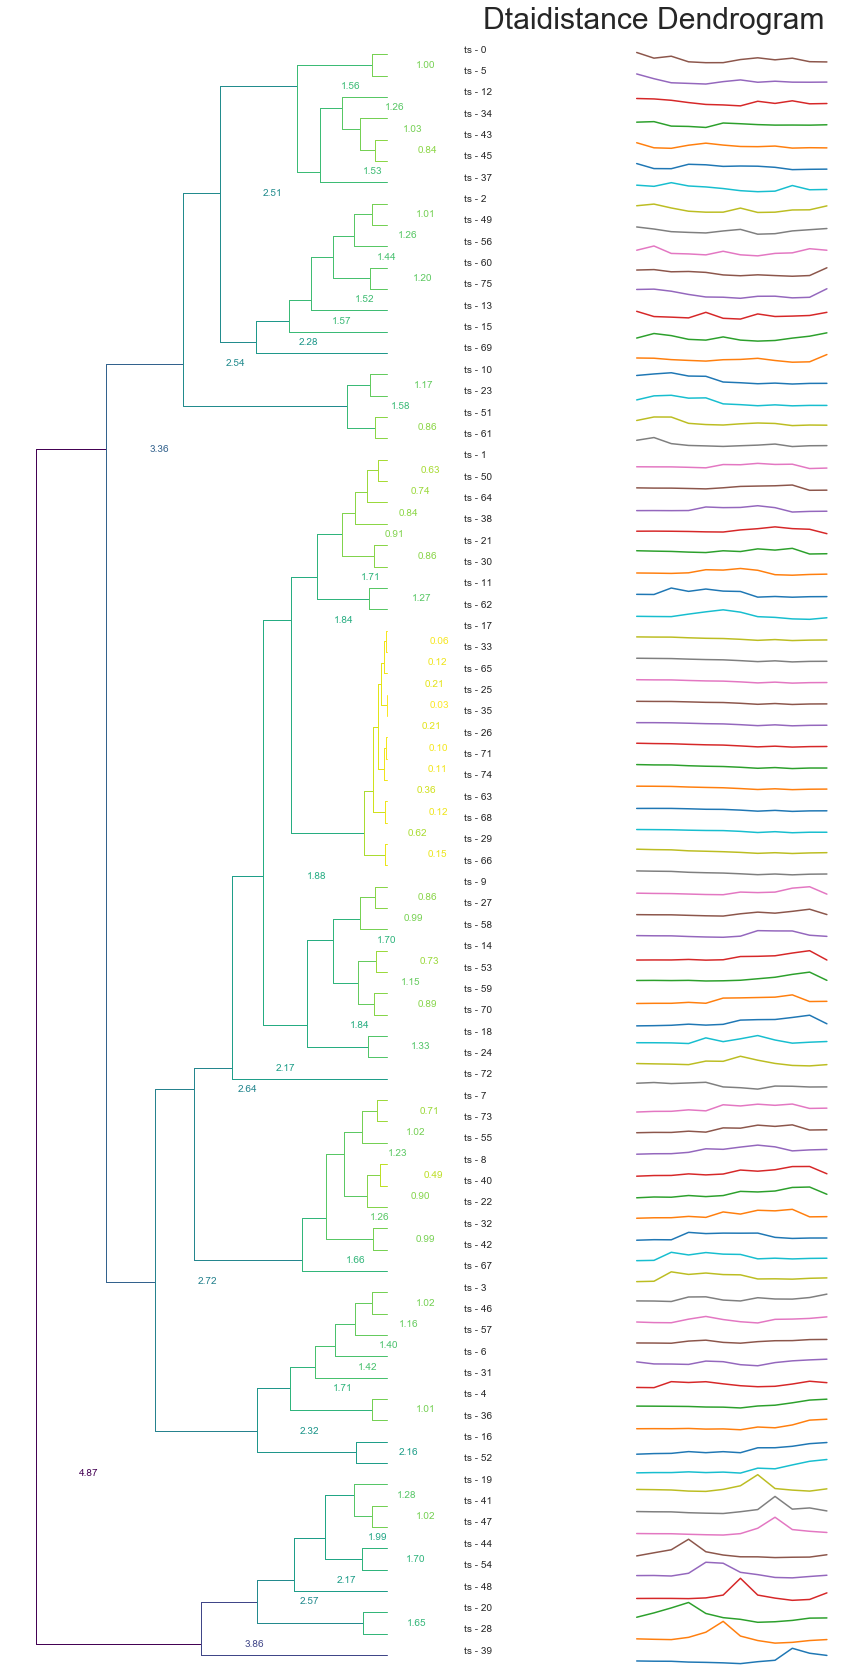

In [5]:
# from dtaidistance clustering documentation
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
model2 = clustering.HierarchicalTree(model1, show_ts_label=True)
cluster_idx = model2.fit(trends)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 30))
show_ts_label = lambda idx: "ts - " + str(idx)
model2.plot(axes=ax, show_ts_label=show_ts_label,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)
plt.title('Dtaidistance Dendrogram', fontsize=30)
plt.show()

While using dtaidistance to create a dendrogram shows the trend shapes to the right, I could not find a way to cut the dendrogram into clusters and return the trend ids within each cluster. I solve this problem by using SciPy's linkage to create a dendrogram, pick a distance at which to cut the dendrogram and then passing the number of clusters into fcluster.

In [6]:
# condensed distance matrix https://stackoverflow.com/questions/18952587/
# format dtw distances to pass to SciPy linkage
condensed_distances = scipy.spatial.distance.squareform(distances)

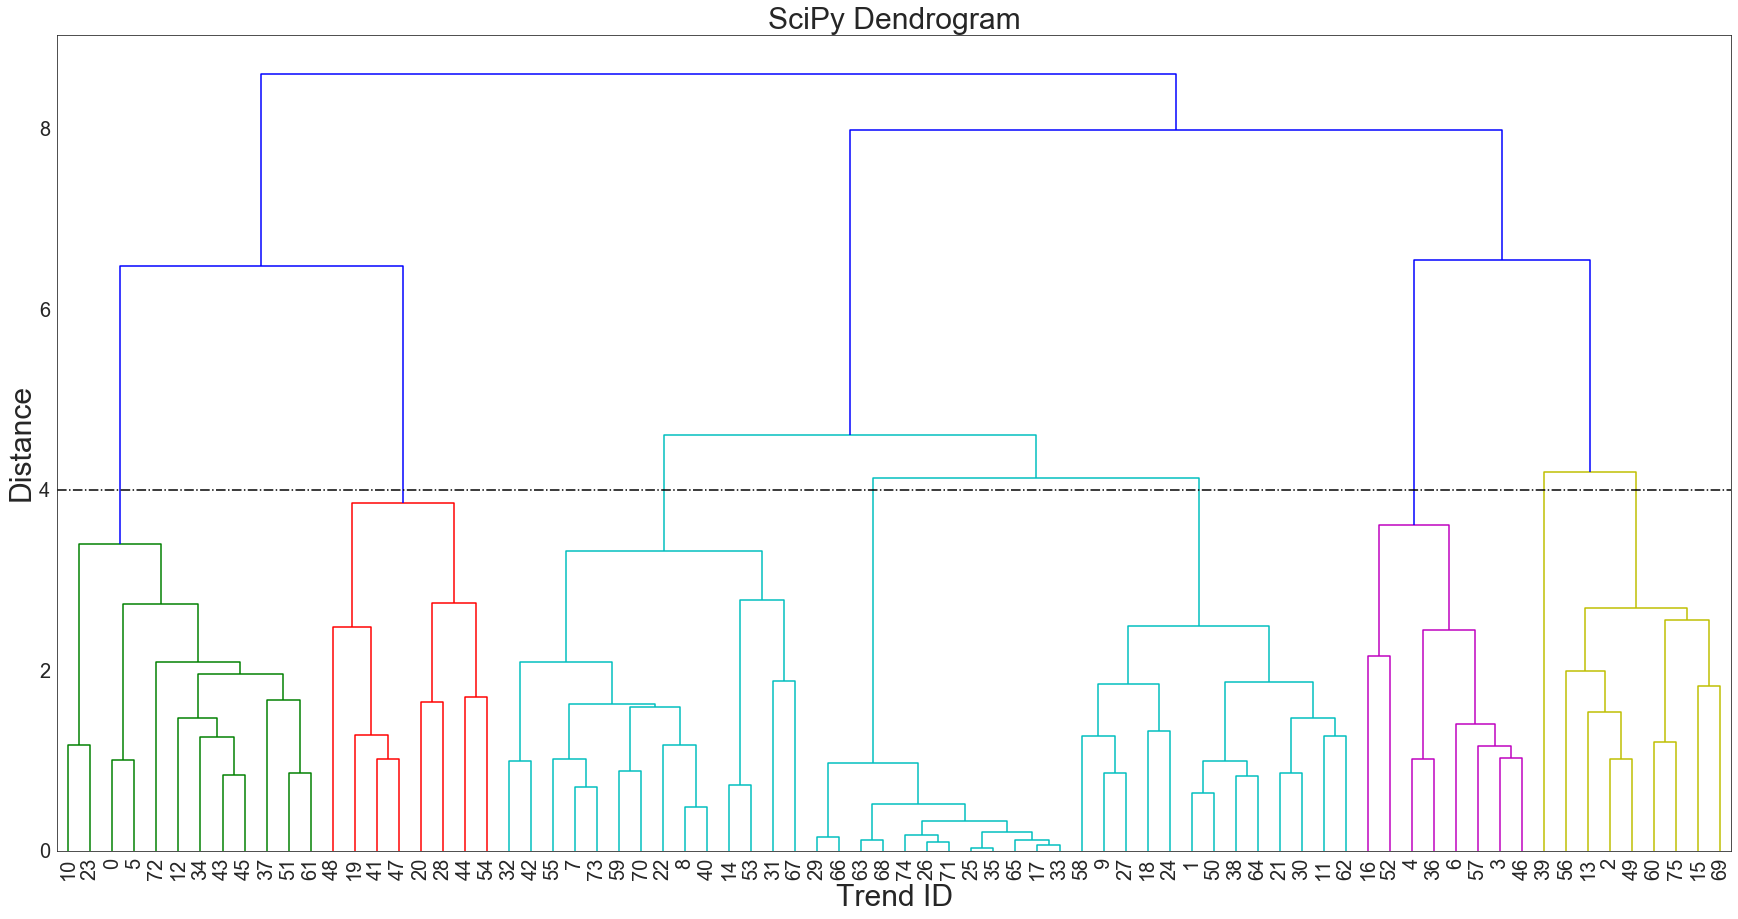

In [7]:
Z = linkage(condensed_distances, method='complete')

fig = plt.figure(figsize=(30, 15))
dn = dendrogram(Z, leaf_font_size=20)
plt.axhline(color='black', linestyle='-.', y=4) 
plt.title('SciPy Dendrogram', fontsize=30)
plt.xlabel('Trend ID', fontsize=30)
plt.ylabel('Distance', fontsize=30)
plt.yticks(size=20)
plt.show()

The dendrogram is cut at distance = 4 which results in 8 clusters. 

In [8]:
num_clusters = 8
labels = fcluster(Z, t=num_clusters, criterion='maxclust')

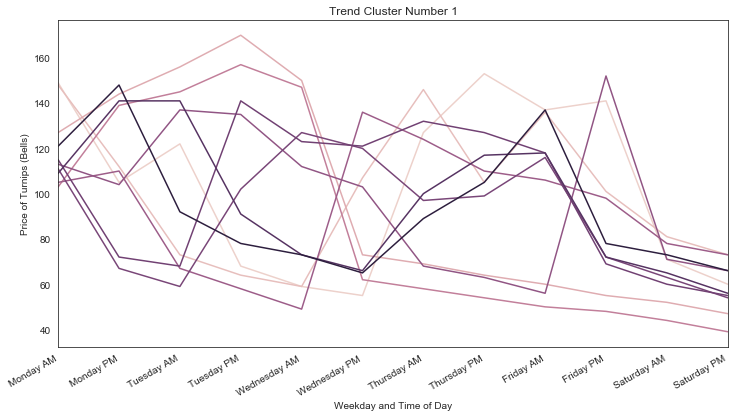

Sample IDs for Cluster Number 1
[ 0  5 10 23 34 37 43 45 51 61]


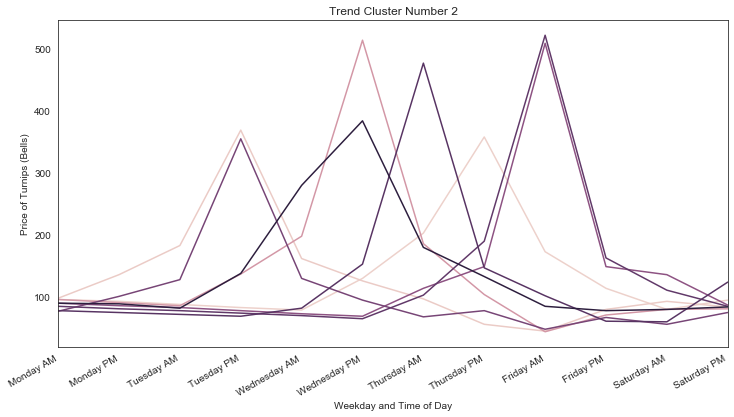

Sample IDs for Cluster Number 2
[19 20 28 41 44 47 48 54]


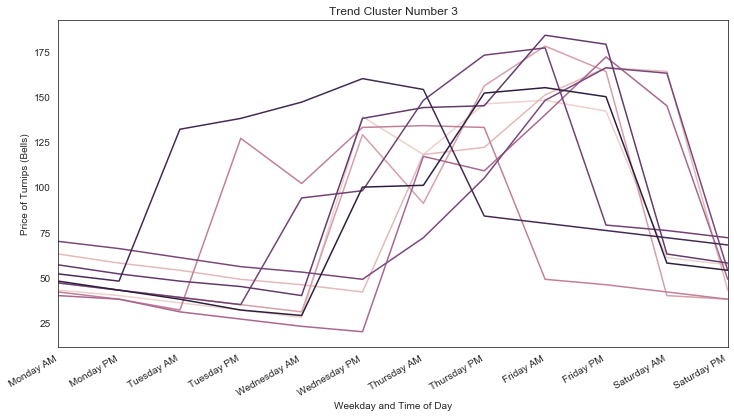

Sample IDs for Cluster Number 3
[ 7 14 22 32 40 53 55 59 67 73]


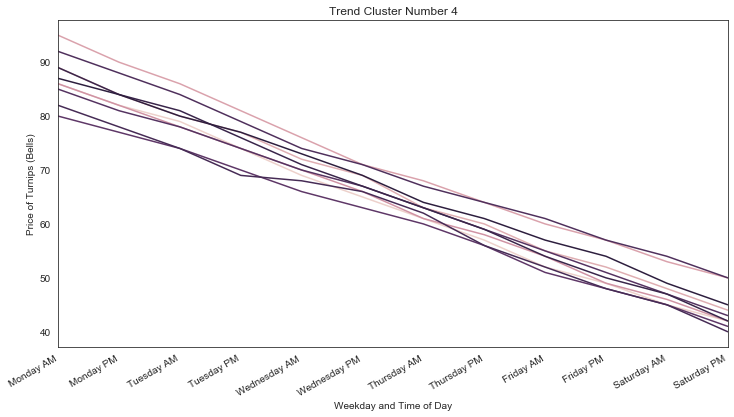

Sample IDs for Cluster Number 4
[17 26 29 33 63 65 66 68 71 74]


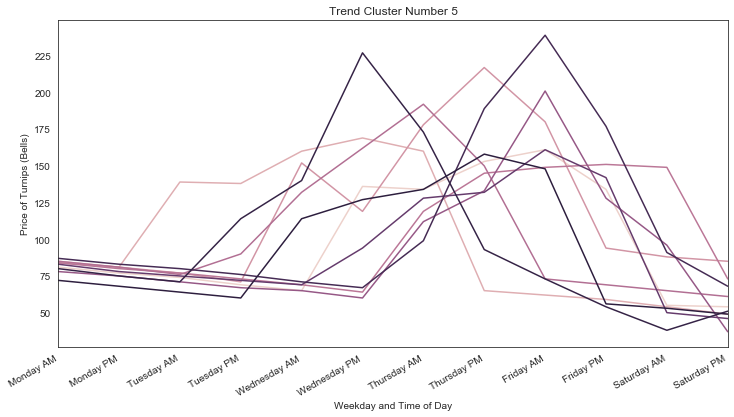

Sample IDs for Cluster Number 5
[ 1 11 18 27 30 38 50 58 62 64]


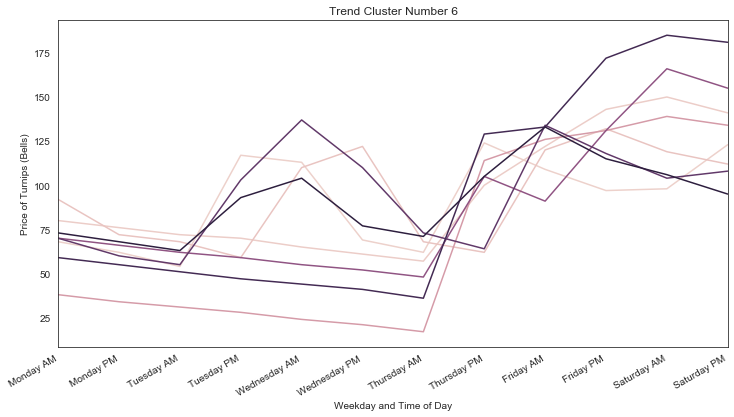

Sample IDs for Cluster Number 6
[ 3  4  6 16 36 46 52 57]


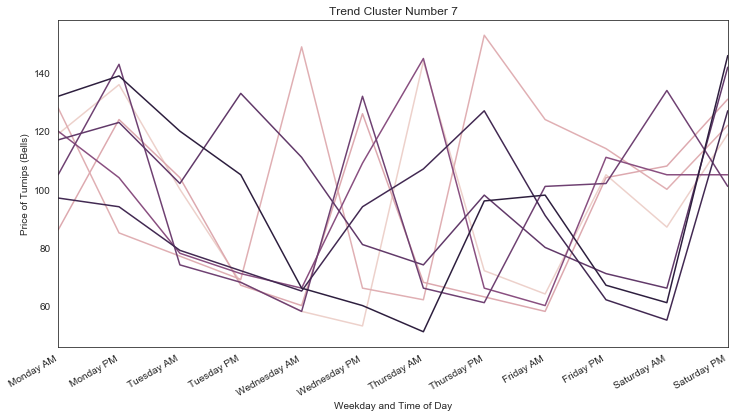

Sample IDs for Cluster Number 7
[ 2 13 15 49 56 60 69 75]


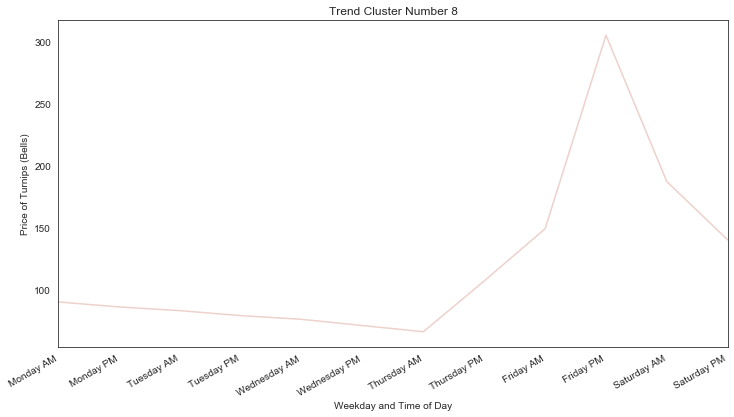

Sample IDs for Cluster Number 8
[39]


In [9]:
plot_trend_samples(sell_data, labels, num_clusters, display_sample_ids=True)

After plotting samples of up to 10 trends from each cluster, clusters 2, 4, and 5 appear to contain big spikes, decreasing trends and small spikes respectively. Cutting the dendrogram at distance = 4 prevents the decreasing trends from being combined with the small spike trends while resulting in cluster 8 which contains single trend. It is important to note that the y-axis scaling is different for each cluster.

In [10]:
clusters = pd.read_csv('data/clusters.csv')
clusters['hierarchical'] = labels
clusters.to_csv('data/clusters.csv', index=False)

In [11]:
connection.close()
engine.dispose()